# Assignment 4: The Traveling Salesman Problem
In our last assignment, we added crossover to the mix, completing the last major piece of our evolutionary algorithm framework!  Let's use this basic pipeline to explore a real-world applied problem to help gain an understanding of the complexity of using respresnetations beyond basic bit-strings.  

In this assignment, we'll explore the Traveling Salesman Problem (TSP).  This problem specifies that a solution should visit each of a list of locations exactly one time, and do so by traveling the shortest distance possible. 

In [1]:
# imports
import numpy as np
import copy
import matplotlib.pyplot as plt
plt.style.use('seaborn')

import scikits.bootstrap as bootstrap
import warnings
warnings.filterwarnings('ignore') # Danger, Will Robinson! (not a scalable hack, and may surpress other helpful warning other than for ill-conditioned bootstrapped CI distributions)

import scipy.stats # for finding statistical significance

from IPython.display import clear_output # for real-time displays
import time # in case you want to analyze runtime of your code
import geopy.distance
import random
import math

Most of my family's road trips are based around getting outside a seeing national parks, so let's optimize a TSP to visit the list of US National Parks.  This list of all parks, and their coordinates, is included in the zip folder for this assignment.  The below block of code will load this data, ignoring the parks outside the continental US (so we can pretend to drive, instead of flying to Alaska or Hawaii).  Ignoring these, we're left with a list of 50 parks (what counts as a "National Park" is a bit fuzzy, but this is the list I scraped from Wikipedia).  For the most part we'll actually be ignoring the `park_names` and working with `park_lat_long`, which is an 2-D array that provides the coordiantes of each park (indexed in alphabetical order to match the names list -- not that this matters much for our purposes in this assignment).  

In [2]:
file = open("parks_list.csv", encoding='utf8')
park_names = []
park_lat_long = []
for line in file: # get name, latitute, and longitude of park from file
    park_name = line.split(",")[0].strip()
    park_lat = float(line.split(",")[1].strip())
    park_long = float(line.split(",")[2].strip())
    
    if park_lat > -125 and park_lat < -65 and park_long > 25 and park_lat < 50: # just look at continental US
        park_names.append(park_name)
        park_lat_long.append([park_lat,park_long])
        
file.close()
park_lat_long = np.array(park_lat_long) # convert to numpy array for easier indexing/slicing

print("Number of National Parks in Continental US:",len(park_names))
print(park_names)

print(park_lat_long)

Number of National Parks in Continental US: 50
['Acadia', 'Arches', 'Badlands', 'Big Bend', 'Biscayne', 'Black Canyon of the Gunnison', 'Bryce Canyon', 'Canyonlands', 'Capitol Reef', 'Carlsbad Caverns', 'Channel Islands', 'Congaree', 'Crater Lake', 'Cuyahoga Valley', 'Death Valley', 'Everglades', 'Gateway Arch', 'Glacier', 'Grand Canyon', 'Grand Teton', 'Great Basin', 'Great Sand Dunes', 'Great Smoky Mountains', 'Guadalupe Mountains', 'Hot Springs', 'Indiana Dunes', 'Isle Royale', 'Joshua Tree', 'Kings Canyon', 'Lassen Volcanic', 'Mammoth Cave', 'Mesa Verde', 'Mount Rainier', 'New River Gorge', 'North Cascades', 'Olympic', 'Petrified Forest', 'Pinnacles', 'Redwood', 'Rocky Mountain', 'Saguaro', 'Sequoia', 'Shenandoah', 'Theodore Roosevelt', 'Voyageurs', 'White Sands', 'Wind Cave', 'Yellowstone', 'Yosemite', 'Zion']
[[ -68.21     44.35  ]
 [-109.57     38.68  ]
 [-102.5      43.75  ]
 [-103.25     29.25  ]
 [ -80.08     25.65  ]
 [-107.72     38.57  ]
 [-112.18     37.57  ]
 [-109.93   

Given that we know the coordinates of each park, a fun dataviz we can do is to superimpose the parks on a map of the United States.

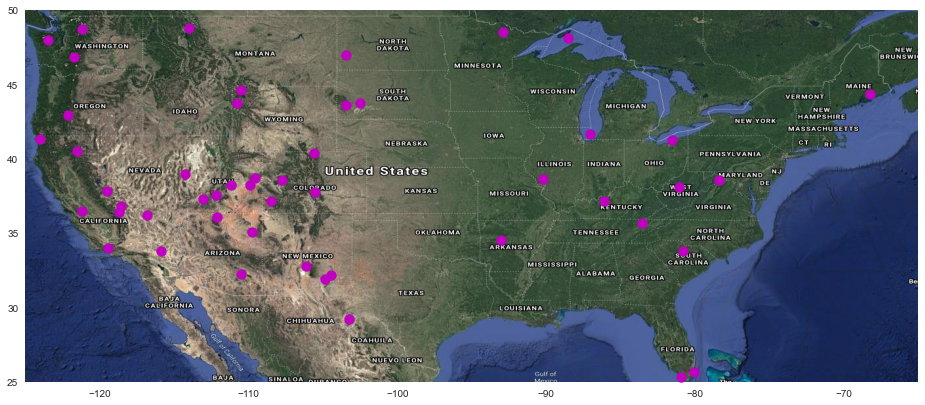

In [3]:
fig, ax = plt.subplots(figsize=(16, 8)) # generate figure and axes
ax.imshow(plt.imread("us_map.png"), extent=[-125, -65, 25, 50]) # import backbround
ax.scatter(park_lat_long[:,0],park_lat_long[:,1],color='m',s=100) # plot each park at its coordinates
ax.set_xlim([-125,-65]);
ax.set_ylim([25,50]);
ax.grid(False);

Since we'll be opitmizing routes between these parks, it would also be good to be able to draw routes between two parks.  For the sake of simplicity (i.e. so you don't need to interface with the Google Maps API), we'll just consider straight-line distance between parks as a proxy for driving distance.  An example of how to draw a line showing a path between parks might look something like this.

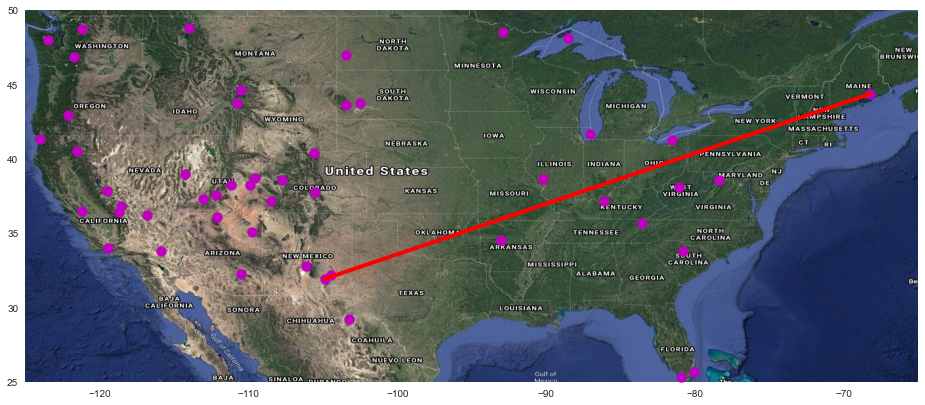

In [4]:
fig, ax = plt.subplots(figsize=(16, 8)) # generate figure and axes
ax.imshow(plt.imread("us_map.png"), extent=[-125, -65, 25, 50]) # import backbround
ax.scatter(park_lat_long[:,0],park_lat_long[:,1],color='m',s=100) # plot each park at its coordinates
ax.set_xlim([-125,-65]);
ax.set_ylim([25,50]);
ax.grid(False);

park1_index = 0 # pick to arbitrary parks for this demo example
park2_index = 23
ax.plot([park_lat_long[park1_index,0],park_lat_long[park2_index,0]],[park_lat_long[park1_index,1],park_lat_long[park2_index,1]],color='r',linewidth=4); # draw a line between them

### Q1: TSP Ftiness Function
Define a fitness function that takes a genome of park indexes and calculates the total round trip distance from the starting point (first park) back around a full cycle to end up at the park you started in.  

Recall that we are using the straight-line distance between parks (and you may find it useful to make a helper function which calculated the distance between any two indidivual parks in calculating the total distance traveled).

To minimize the modifications necessary to your existing evolutionary algorithm code, which maximized fitness, return the negative of the distance traveled (i.e. fitness will always be less than zero, with longer trips more negative), so we can continue to maximize fitness values when finding the shortest part for the TSP.

*Hint:* Even though the fitness function definition comes first, it may be easier to complete after defining the genome representation below

In [5]:
def distance_between_parks(park1_index,park2_index):
    """ Optional helper function to calculate straight-line distance between two parks
        
        parameters: 
        park1_index: (int) location of first park in genome
        park2_index: (int) location of second park in genome
        
        returns:
        distance: (float) straight-line distance between parks
    """
    

    coords_1 = (park_lat_long[park1_index,1], park_lat_long[park1_index,0])
    coords_2 = (park_lat_long[park2_index,1], park_lat_long[park2_index,0])

#     return geopy.distance.distance(coords_1, coords_2).km
    
    # earth radius
    R = 6373.0

    
    lat1 = math.radians(coords_1[0])
    lon1 = math.radians(coords_1[1])

    lat2 = math.radians(coords_2[0])
    lon2 = math.radians(coords_2[1])

    # distance
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    # Haversine formula
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2

    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    distance = R * c
    
#     distance = 1. * (math.sqrt((coords_2[0] - coords_1[0])**2 + (coords_2[1] - coords_1[1])**2))
    
    return distance



    

def traveling_salesman_fitness_function(genome):
    """ Fitness function for TSP.  Round trip (i.e. full cycle) distance traveled by the "traveling salesman"
        
        parameters: 
        genome: (numpy array) individual's genome containing ordered list of parks to visit
        
        returns:
        distance: (float) straight-line total distance for visiting all parks
    """
    fitness = 0
    for i in range(len(genome)):
        if i + 1 == len(genome):
            fitness+=distance_between_parks(genome[i], genome[0])
        else:
            fitness += distance_between_parks(genome[i], genome[i+1])
    
    return -1.*fitness
        
    
genome = list(range(0,50))
traveling_salesman_fitness_function(genome)

-85943.84682919852

### Q2: Adapting the Evolutionary Algorithm for the TSP
Copy over your evolutionary algorithm code (both the `Individual` class and the `evolutionary_algorithm` function) from your last assignemnt (or the posted solutions) to provide a framework to get started with.  Now please adopt this code to sovle the TSP.  Let's begin with the simple case of just mutation and not crossover.  Let's also focus on the simpler case of a hard constraint on visiting each loaction just once.  

We mentioned a number of potential representations in class last week, please pick one that enforces each location be visited only once as part of the encoding.  

Let's also begin with a mutation opperator we discussed in class, randomly selecting two locations and swapping their place in the visitation order.  

Additionally, for visualizations later on, please save the timeseries of solutions over time (in addition to the fitness values over time you were saving last assignment).

*Hint*: If your genome is a set of indexes, don't forget that they need to be ints (not floats).

*Hint*: If you're fitness values are all negative, keep this in mind when initializing your best-solution-so-far value.

In [6]:
class Individual:
    
    def __init__(self, fitness_function, genome_length):
        self.fitness_function = fitness_function
        self.genome = np.array(list(range(0,genome_length)))
        np.random.shuffle(self.genome)
        self.fitness = 0
        
    def eval_fitness(self):
        self.fitness = self.fitness_function(self.genome)

In [7]:
def evolutionary_algorithm(fitness_function=None, total_generations=100, num_parents=10, num_children=10, genome_length=10, num_elements_to_mutate=1, crossover=True, tournament_size=4, num_tournament_winners=2):
    """ Evolutinary Algorithm (copied from the basic hillclimber in our last assignment)
        
        parameters: 
        fitness_funciton: (callable function) that return the fitness of a genome 
                           given the genome as an input parameter (e.g. as defined in Landscape)
        total_generations: (int) number of total iterations for stopping condition
        num_parents: (int) the number of parents we downselect to at each generation (mu)
        num_childre: (int) the number of children (note: parents not included in this count) that we baloon to each generation (lambda)
        genome_length: (int) length of the genome to be evoloved
        num_elements_to_mutate: (int) number of alleles to modify during mutation (0 = no mutation)
        crossover: (bool) whether to perform crossover when generating children 
        tournament_size: (int) number of individuals competing in each tournament
        num_tournament_winners: (int) number of individuals selected as future parents from each tournament (must be less than tournament_size)
        
        returns:
        fitness_over_time: (numpy array) track record of the top fitness value at each generation
        solutions_over_time: (numpy array) track record of the top genome value at each generation
    """

    # initialize record keeping
    fitness_over_time = []
    solutions_over_time = []
    
    # the initialization proceedure
    parents = []
    children = []
    for i in range(num_parents):
        parents.append(Individual(fitness_function, genome_length))
    
    # get population fitness
    for i in range(num_parents):
        parents[i].eval_fitness()
    
    for i in range(total_generations): # repeat
        
        # the modification procedure
        children = []
        
        # inheretance
        if not crossover:
            while len(children) < num_children:
                parent1 = random.choice(parents)
                parent2 = random.choice(parents)
                children.append(copy.deepcopy(parent1))
                children.append(copy.deepcopy(parent2))
#             children = copy.deepcopy(parents)
            
        # mutation
        if num_elements_to_mutate > 0:
            # loop through each child
            for j in range(len(children)):
                
                # create storage array for elements to mutate
                elements_mutated = []
                elements_mutated = random.sample(range(0,genome_length), num_elements_to_mutate*2)
                        
                # loop through the array of indices to be mutated
                for k in range(0, len(elements_mutated), 2):
                    # swap the two values in the list
                    one = children[j].genome[elements_mutated[k]]
                    two = children[j].genome[elements_mutated[k+1]]
                    children[j].genome[elements_mutated[k+1]] = one
                    children[j].genome[elements_mutated[k]] = two
            
        # the assessement procedure
        for j in range(num_children):
            children[j].eval_fitness()

        # selection procedure
        parents += copy.deepcopy(children)
        parents = sorted(parents, key=lambda x: x.fitness, reverse=True)
        new_parents = []
        
        # loop for the number of parents that we want
        while len(new_parents) < num_parents:
            tournament = np.random.choice(parents, size=tournament_size)
            tournament = sorted(tournament, key=lambda individual: individual.fitness, reverse=True)
            new_parents.extend(tournament[:num_tournament_winners])
                
        # once we have enough new_parents to fill our parents array for the next generation, sort these
        # and select the exact number of parents we want for the next generation
        parents = sorted(new_parents, key=lambda x: x.fitness, reverse=True)[:num_parents]
#         for z in range(10):
#             print(parents[z].fitness)
        
        # record keeping
        fitness_over_time.append(parents[0].fitness)
        solutions_over_time.append(parents[0].genome)
        random.shuffle(parents)
    
    return fitness_over_time, solutions_over_time

As usual, let's store our results for later plotting

In [8]:
experiment_results = {}
solutions = {}

### Q2: Collect and Analyze Results
Similar to last week, let's run multiple trials to systematically test our algorithm.  To keep compute times down, let's start with a smaller subset of the problem, using just the first half of the parks in our dataset.  

In [9]:
park_names = park_names[:25]
park_lat_long = park_lat_long[:25]

In this smaller problem, let's run for `100` generations, `50` parents + `50` childeren in a mu+alpha evolutionary strategies, a tournament selection of tournaments of size `10` with `2` winners selected at each tournament.  Let's just run this for `20` independent trials.  

For reference (as there were runtime length questions about the last assignment), in my implementation of this, each run taks a little over a second, so all 20 runs finish in under 30 seconds.  

In [10]:
num_runs = 20
total_generations = 100
num_elements_to_mutate = 1
genome_length = len(park_names)
num_parents = 50
num_children = 50
tournament_size = 10
num_tournament_winners = 2
fitness_function = traveling_salesman_fitness_function
crossover = False

experiment_results['first'] = []
solutions['first'] = []

for i in range(num_runs):
    first_fit, first_sol = evolutionary_algorithm(fitness_function, total_generations, num_parents, num_children, genome_length, num_elements_to_mutate, crossover, tournament_size, num_tournament_winners)
    experiment_results['first'].append(first_fit)
    solutions['first'].append(first_sol)

Again pulling from the previous assignment, please plot the mean and boostrapped confidence interval of your experiements.  Again, you may find it convenient to make this into a function (and if you do, FYI, later use cases may involve plotting just the mean without the CI, since this boostrapping proceedure can be computationally expensive).  

In [11]:
def plot_mean_and_bootstrapped_ci_over_time(input_data = None, name = "change me", x_label = "change me", y_label="change me", y_limit = None, plot_bootstrap = True):
    """
    
    parameters: 
    input_data: (numpy array of shape (max_k, num_repitions)) solution metric to plot
    name: (string) name for legend
    x_label: (string) x axis label
    y_label: (string) y axis label
    
    returns:
    None
    """
         
    print(input_data.shape)
    generations = input_data.shape[0]

    CIs = []
    mean_values = []
    for i in range(generations):
        mean_values.append(np.mean(input_data[i]))
        CIs.append(bootstrap.ci(input_data[i], statfunction=np.mean))
    mean_values=np.array(mean_values)
    
    print(CIs)
    high = []
    low = []
    for i in range(len(CIs)):
        low.append(CIs[i][0])
        high.append(CIs[i][1])
    
    low = np.array(low)
    high = np.array(high)
    fig, ax = plt.subplots()
    y = range(0, generations)
    ax.plot(y, mean_values, label=name)
    ax.fill_between(y, high, low, color='b', alpha=.2)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.legend()
    if (name) and len(name)>0:
        ax.set_title(name)
    
    


(100, 20)
[array([-34907.90966719, -33064.33786632]), array([-33451.0906965 , -31468.79824363]), array([-32712.06017286, -30727.64153681]), array([-31534.77260187, -29535.03006818]), array([-30293.57875661, -28580.47884401]), array([-29568.68516301, -27708.95068312]), array([-28754.88577824, -27037.47080984]), array([-27696.26035534, -26335.32341861]), array([-27206.77938678, -25840.5437868 ]), array([-26579.98104049, -25196.97371421]), array([-25792.84687456, -24645.4880627 ]), array([-25414.55806256, -24173.89876812]), array([-25016.71551104, -23801.5737228 ]), array([-24553.11876858, -23350.88164569]), array([-24111.01370624, -22818.36548824]), array([-23634.7221322 , -22431.02125299]), array([-23503.91126061, -22251.65667506]), array([-23124.5167501 , -21932.96835011]), array([-22941.51647496, -21838.20870144]), array([-22666.79408481, -21604.01154634]), array([-22480.10456231, -21355.89908539]), array([-22249.72380318, -21122.2330932 ]), array([-22099.25877792, -20943.66684437]), 

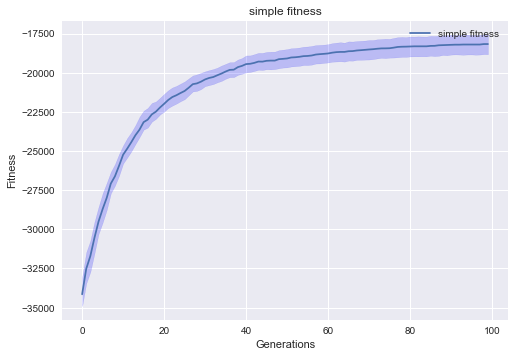

In [12]:
# plotting
plot_mean_and_bootstrapped_ci_over_time(input_data=np.transpose(np.array(experiment_results['first'])), name='simple fitness', y_label="Fitness", x_label='Generations')
# plot_mean_and_bootstrapped_ci_over_time(input_data=np.transpose(np.array(solutions['first'])), name='simple solutions', y_label="Solutions", x_label='Generations')

One of the most fun parts of working in machine learning (for me) is to see the solutions take shape over time.  Here's I've written a function that takes in your solutions_over_time from a single trial run above, and visualizes its optimization over time.

In [13]:
def show_solution_evolution(solutions_over_time, final_solution_only= False):
    """ Show animation of evolutionary optimization for TSP.
    
    parameters: 
    solutions_over_time: (numpy array) track record of the top genome value at each generation
    final_solution_only: (bool) flag to skip animation
    
    returns:
    None
    """
    
    solutions_over_time = solutions_over_time.astype(int) # in case you forgot to cast array type
    
    last_fitness = 0
    for i in range(total_generations):
        
        if final_solution_only: i = total_generations-1 # skip to end if not showing full animation
        
        genome = solutions_over_time[i]
        fitness = traveling_salesman_fitness_function(genome)

        if fitness != last_fitness: # only show new solution, if different from the last generation
            last_fitness = fitness
            print("Generation:",i,"\nFitness:",fitness)
            clear_output(wait=True) # erase prior figure to enable animation
            fig, ax = plt.subplots(figsize=(16, 8)) # generate figure and axes
            ax.grid(False)

            ax.imshow(plt.imread("us_map.png"), extent=[-125, -65, 25, 50]) # plot map background
            ax.scatter(park_lat_long[:,0],park_lat_long[:,1],color='m',s=100) # plot park points
            ax.set_xlim([-125,-65]);
            ax.set_ylim([25,50]);

            for park_index in range(len(genome)): # for each park in the solution
                ax.plot([park_lat_long[genome[park_index],0],park_lat_long[genome[(park_index+1)%len(genome)],0]],[park_lat_long[genome[park_index],1],park_lat_long[genome[(park_index+1)%len(genome)],1]],color='r',linewidth=4) # draw a line from it to the following park (looping back around to start when at end)
            plt.show()

    last_fitness = fitness
    print("Generation:",i,"\nFitness:",fitness)

### Q3: Inspecting Results
Write a quick script to find the best performing single run that you've found so far, and show its evolution over time using the `show_solution_evolution` funciton given above.  

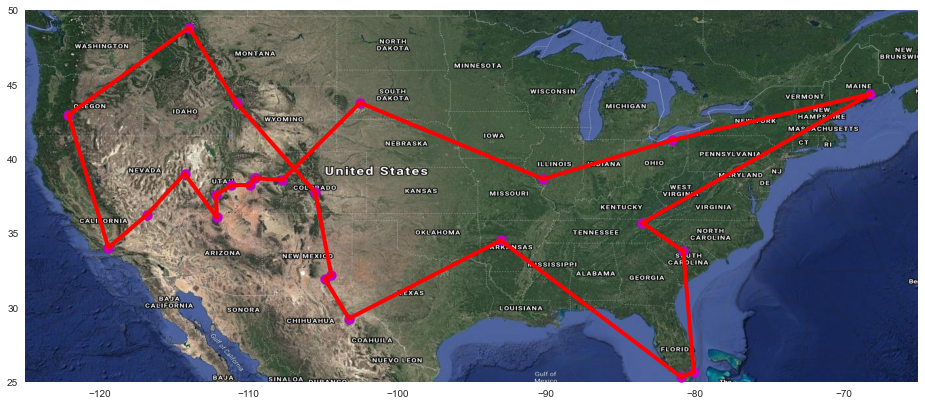

Generation: 99 
Fitness: -15514.045532842993


In [15]:
# plot best solution found thus far as interactive plot
best = 0
for i in range(len(experiment_results['first'])):
    if max(experiment_results['first'][best]) < max(experiment_results['first'][i]):
        best = i
show_solution_evolution(np.array(solutions['first'][best]))

### Q3b: Applying Intuition
One of the nice parts about viewing the solutions coming together over time is that you can see the stepping stones taken to get to good solutions, or where your algorithm may have gotten stuck.  Do the results that you see make sense?  Do you notice anything in particular about the intermediate solutions or search strategy that might inform further algorithmic ideas for the TSP?

**The results I see here make sense to me. I think the algorithm with such high tournament selection ends up creating a very narrow population that doesn't explore much with such small mutations. The stepping stones seem to be either subnetworks in a smaller area of the map or finding edges around the outer points on the map. This could suggest that looking for subnetworks or looking at the points that have higher distances from other points is a decent strategy for determing where to travel next.**

### Q4: Alternative Mutation Opperators
What's a different mutation opperator that you might wanto to implement?  

One that comes to mind for me would be the idea of randomly moving a single entry (gene/park) to another random location in the genome (vs. swapping two).  

What are the potential implication that you could see stemming from this change (or whatever other alternative mutation opperator you want to implement below)?

**What if we just take a random entry and put it at the end? The potential implication is that this will find good orderings of entries toward the end of the array. The one that you proposed, would also be interesting since it will probably find good orderings where the mutation occurs. Since we aren't swapping, this feels like a smaller change, but I'm not sure that it is. Since we are moving the single entry, this effects mostly the two entries on either side where the single entry was removed as well as itself and both entries on either side of where it was placed. In my case, only the single entry that is at the end of the list. This may be a smaller change that swapping since this will effect the two entries swapped as well ast the four entries (two for each) on either side of them. This could help with climbing if the landscape is simple enough, but it could also be detrimental if my analysis above is flawed or if the landscape is more rugged. Moving the entry to the end of the array does introduce some positional bias for the mutation.**

### Q4b:  Implementation
Implement this mutation opperator in the cell below

In [76]:
def evolutionary_algorithm(fitness_function=None, total_generations=100, num_parents=10, num_children=10, genome_length=10, num_elements_to_mutate=1, crossover=True, tournament_size=4, num_tournament_winners=2):
    """ Evolutinary Algorithm (copied from the basic hillclimber in our last assignment)
        
        parameters: 
        fitness_funciton: (callable function) that return the fitness of a genome 
                           given the genome as an input parameter (e.g. as defined in Landscape)
        total_generations: (int) number of total iterations for stopping condition
        num_parents: (int) the number of parents we downselect to at each generation (mu)
        num_childre: (int) the number of children (note: parents not included in this count) that we baloon to each generation (lambda)
        genome_length: (int) length of the genome to be evoloved
        num_elements_to_mutate: (int) number of alleles to modify during mutation (0 = no mutation)
        crossover: (bool) whether to perform crossover when generating children 
        tournament_size: (int) number of individuals competing in each tournament
        num_tournament_winners: (int) number of individuals selected as future parents from each tournament (must be less than tournament_size)
        
        returns:
        fitness_over_time: (numpy array) track record of the top fitness value at each generation
        solutions_over_time: (numpy array) track record of the top genome value at each generation
    """

        # initialize record keeping
    fitness_over_time = []
    solutions_over_time = []
    
    # the initialization proceedure
    parents = []
    children = []
    for i in range(num_parents):
        parents.append(Individual(fitness_function, genome_length))
    
    # get population fitness
    for i in range(num_parents):
        parents[i].eval_fitness()
    
    for i in range(total_generations): # repeat
        
        # the modification procedure
        children = []
        
        # inheretance
        if not crossover:
            children = copy.deepcopy(parents)
            
        # crossover
        if crossover:
            while len(children)<(num_children):
                random.shuffle(parents)
                for j in range(0, num_parents, 2):

                    # select both parents
                    first_parent = parents[j]
                    second_parent = parents[j+1]
                
                    # randomly select two points for crossover
                    crossover_points = random.sample(range(0,genome_length), 2)
                    
                    # Do we want to disallow crossover from higher to lower numbers?
                    # TODO: Remove below line and edit crossover to work when higher number is first as well
                    crossover_points = sorted(crossover_points)
                    
                    # switch genes between these two points between the two individuals
                    child1 = Individual(fitness_function, genome_length)
                    child1.genome = parents[j].genome[:crossover_points[0]] + parents[j+1].genome[crossover_points[0]:crossover_points[1]] + parents[j].genome[crossover_points[1]:]
                    child2 = Individual(fitness_function, genome_length)
                    child2.genome = parents[j+1].genome[:crossover_points[0]] + parents[j].genome[crossover_points[0]:crossover_points[1]] + parents[j+1].genome[crossover_points[1]:]
                    
                    # Or do we just keep the children no matter what
                    children.append(child1)
                    children.append(child2)
                    
            
            if len(children) > num_children:
                children = children[:num_children]
            
        # mutation
        if num_elements_to_mutate > 0:
            # loop through each child
            for j in range(len(children)):
                
                # create storage array for elements to mutate
                elements_mutated = []
                elements_mutated = random.sample(range(0,genome_length), num_elements_to_mutate)
                elements_mutated2 = random.sample(range(0,genome_length), num_elements_to_mutate*2)
                        
                # loop through the array of indices to be mutated
                # loop through the array of indices to be mutated
                for k in range(0, len(elements_mutated)):
                    # place the element at the end of the array
                    children[j].genome = np.append(children[j].genome, children[j].genome[elements_mutated[k]])
                    for l in range(elements_mutated[k], genome_length):
                        children[j].genome[l] = children[j].genome[l+1]
                    children[j].genome = children[j].genome[:genome_length]
                    # place the element in a random location
#                     children[j].genome[elements_mutated2[k]] = children[j].genome[elements_mutated2[k+(len(elements_mutated2)/2)]]
        
        # the assessement procedure
        for j in range(num_children):
            children[j].eval_fitness()

        # selection procedure
        parents += copy.deepcopy(children)
        random.shuffle(parents)
        new_parents = []
        
        # loop for the number of parents that we want
        while len(new_parents) < num_parents:
            random.shuffle(parents)
            for j in range(0, len(parents), tournament_size):
                winners = []
                for k in range(0, tournament_size):
                    if len(parents) <= j+k:
                        winners.append(parents[random.randint(0,len(parents)-1)])
                    else:
                        winners.append(parents[j+k])
                winners = sorted(winners, key=lambda x: x.fitness, reverse=True)
                winners = winners[:num_tournament_winners]
                new_parents += winners
        
        parents = sorted(new_parents, key=lambda x: x.fitness, reverse=True)[:num_parents]
        
        # record keeping
        fitness_over_time.append(parents[0].fitness)
        solutions_over_time.append(parents[0].genome)
    
    return fitness_over_time, solutions_over_time

### Q5: Run and Plot Experiment
Yeah, do that.

In [84]:
num_runs = 20
total_generations = 100
num_elements_to_mutate = 1
genome_length = len(park_names)
num_parents = 50
num_children = 50
tournament_size = 10
num_tournament_winners = 2
crossover = False

experiment_results['first'] = []
solutions['first'] = []

for i in range(num_runs):
    first_fit, first_sol = evolutionary_algorithm(fitness_function, total_generations, num_parents, num_children, genome_length, num_elements_to_mutate, crossover, tournament_size, num_tournament_winners)
    experiment_results['first'].append(first_fit)
    solutions['first'].append(first_sol)

(100, 20)
[array([-35160.65987872, -33491.21576746]), array([-34029.30644782, -32545.62049875]), array([-33525.90204583, -32166.73390471]), array([-33314.60368209, -31981.7694085 ]), array([-33322.42577023, -31987.81405058]), array([-33243.88783398, -31919.54996673]), array([-33256.83974721, -31938.5967433 ]), array([-33266.4489974 , -31937.35802777]), array([-33222.37025749, -31832.43295037]), array([-33210.53872013, -31834.22972512]), array([-33192.53361713, -31820.82558211]), array([-33204.90621476, -31813.82171313]), array([-33219.05038235, -31831.88192819]), array([-33215.02522998, -31822.81914401]), array([-33199.64423988, -31808.60055589]), array([-33192.6197146, -31817.6269099]), array([-33211.08463898, -31834.21894619]), array([-33220.42038575, -31810.01479222]), array([-33191.17264756, -31818.12178571]), array([-33222.44751976, -31800.56250942]), array([-33215.29767097, -31824.08885226]), array([-33214.62857153, -31839.87671087]), array([-33222.22339   , -31822.74833411]), ar

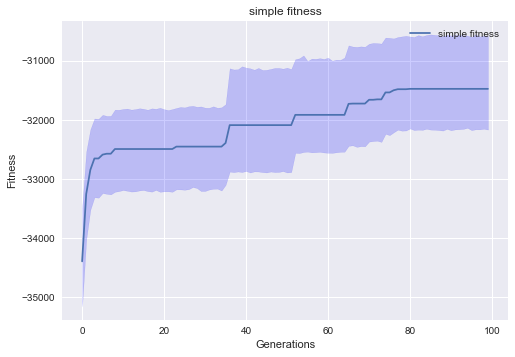

In [85]:
# plotting
plot_mean_and_bootstrapped_ci_over_time(input_data=np.transpose(np.array(experiment_results['first'])), name='simple fitness', y_label="Fitness", x_label='Generations')

It may also be helpful (or just fun) to visualize the evolution over time as well.  

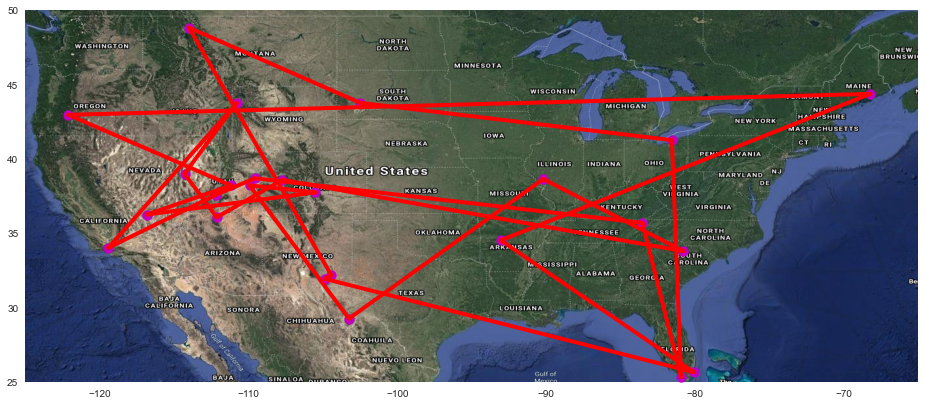

Generation: 99 
Fitness: -33905.984560815836


In [88]:
# interactive viz
# plot best solution found thus far as interactive plot
best = 0
for i in range(len(experiment_results['first'])):
    if max(experiment_results['first'][best]) > max(experiment_results['first'][i]):
        best = i
show_solution_evolution(np.array(solutions['first'][best]))

### Q5b: Analysis
Did this approach work better?  Worse?  Indistinguishable from the first?  Was this what you expected?  What does the difference in mutation opperator performance suggest to you about the methods or benefits of crossover?

**Looks worse. This is understandable given that the first suffered from not exploring enough either and this, I think, is probably an even smaller mutation. It doesn't look like this mutation was able to find a stepping stone very often or at all in some cases and is thus left to the best of the initial population. I think this suggests that using crossover will help since it will add a more exploratory approach to the solution-space. I think the method for crossover should be a more significant change than the mutation operator.**

### Q6: Crossover
Let's also implement a crossover for the TSP.  There are many approaches to crossover that may be appropriate, and you should feel free to choose any (e.g. the simplest) you want.  I would encourage you to think about crossover approaches that maintain the visit-each-location-once hard constraint as part of the crossover mechanism (but as dicussed in class, you're welcome to also explore approaches that visit each location multiple times, then prune down to a single complete cycle before sending the resulting genome off for evaluation).  

If you're short on ideas, [this paper](https://www.hindawi.com/journals/cin/2017/7430125/) has a few examples that might be fun to implement.  

For simplicity's sake, feel free to just add crossover in addition to your favorite of the already implemented mutation opperators (rather than having to explore every permutation of mutation and/or crossover approaches).  I'll just tell you that crossover on its own (given the hyperparameters we have here) doesn't work particularly well -- as you might expect and we discussed in class.  

In [97]:
def evolutionary_algorithm(fitness_function=None, total_generations=100, num_parents=10, num_children=10, genome_length=10, num_elements_to_mutate=1, crossover=True, tournament_size=4, num_tournament_winners=2):
    """ Evolutinary Algorithm (copied from the basic hillclimber in our last assignment)
        
        parameters: 
        fitness_funciton: (callable function) that return the fitness of a genome 
                           given the genome as an input parameter (e.g. as defined in Landscape)
        total_generations: (int) number of total iterations for stopping condition
        num_parents: (int) the number of parents we downselect to at each generation (mu)
        num_childre: (int) the number of children (note: parents not included in this count) that we baloon to each generation (lambda)
        genome_length: (int) length of the genome to be evoloved
        num_elements_to_mutate: (int) number of alleles to modify during mutation (0 = no mutation)
        crossover: (bool) whether to perform crossover when generating children 
        tournament_size: (int) number of individuals competing in each tournament
        num_tournament_winners: (int) number of individuals selected as future parents from each tournament (must be less than tournament_size)
        
        returns:
        fitness_over_time: (numpy array) track record of the top fitness value at each generation
    """

   # initialize record keeping
    fitness_over_time = []
    solutions_over_time = []
    
    # the initialization proceedure
    parents = []
    children = []
    for i in range(num_parents):
        parents.append(Individual(fitness_function, genome_length))
    
    # get population fitness
    for i in range(num_parents):
        parents[i].eval_fitness()
    
    for i in range(total_generations): # repeat
        
        # the modification procedure
        children = []
        
        # inheretance
        if not crossover:
            children = copy.deepcopy(parents)
            
        # crossover
        if crossover:
            while len(children)<(num_children):
                random.shuffle(parents)
                for j in range(0, num_parents, 2):

                    # select both parents
                    first_parent = parents[j]
                    second_parent = parents[j+1]
                
                    # randomly select two points for crossover
                    crossover_points = random.sample(range(0,genome_length), 2)
                    
                    # Do we want to disallow crossover from higher to lower numbers?
                    # TODO: Remove below line and edit crossover to work when higher number is first as well
                    crossover_points = sorted(crossover_points)
                    
                    # switch the tail end of the genomes at this point between the two individuals
                    child1 = Individual(fitness_function, genome_length)
                    child2 = Individual(fitness_function, genome_length)
                    child1.genome = np.array([None for x in range(0,genome_length)])
                    child2.genome = np.array([None for x in range(0,genome_length)])
                    child1.genome = np.concatenate([parents[j].genome[:crossover_points[0]], parents[j+1].genome[crossover_points[0]:crossover_points[1]], parents[j].genome[crossover_points[1]:]])
                    child2.genome = np.concatenate([parents[j+1].genome[:crossover_points[0]], parents[j].genome[crossover_points[0]:crossover_points[1]], parents[j+1].genome[crossover_points[1]:]])
                    
                    # for each of these two children look at the genomes to find duplicate cities
                    # get the indices of the duplicate cities
                    duplicate_indices1 = []
                    for k in range(crossover_points[0], crossover_points[1]):
                        if (child1.genome[k] in child1.genome[:crossover_points[0]]) or (child1.genome[k] in child1.genome[crossover_points[1]:]):
                            duplicate_index = (np.where(child1.genome == child1.genome[k]))[0]
                            duplicate_index = [d for d in duplicate_index if d not in range(crossover_points[0], crossover_points[1])][0]
                            duplicate_indices1.append(duplicate_index)
                    
                    duplicate_indices2 = []
                    for k in range(crossover_points[0], crossover_points[1]):
                        if (child2.genome[k] in child2.genome[:crossover_points[0]]) or (child2.genome[k] in child2.genome[crossover_points[1]:]):
                            duplicate_index = (np.where(child2.genome == child2.genome[k]))[0]
                            duplicate_index = [d for d in duplicate_index if d not in range(crossover_points[0], crossover_points[1])][0]
                            duplicate_indices2.append(duplicate_index)
                                        
                    # loop through the indices that are duplicates and replace the value with the next value in the original parent.
                    for k in duplicate_indices1:
                        for l in range(crossover_points[0], crossover_points[1]):
                            if parents[j].genome[l] not in child1.genome:
                                child1.genome[k] = parents[j].genome[l]
                                l = crossover_points[1]
                            else:
                                continue

                    # loop through the indices that are duplicates and replace the value with the next value in the original parent.
                    for k in duplicate_indices2:
                        for l in range(crossover_points[0], crossover_points[1]):
                            if parents[j+1].genome[l] not in child2.genome:
                                child2.genome[k] = parents[j+1].genome[l]
                                l=crossover_points[1]
                            else:
                                continue
                    
                    if len(np.unique(child1.genome)) + len(np.unique(child2.genome)) < 50:
                        return
                                                                
                    # Or do we just keep the children no matter what
                    children.append(child1)
                    children.append(child2)
                    
            
            if len(children) > num_children:
                children = children[:num_children]
            
        # mutation
        if num_elements_to_mutate > 0:
            # loop through each child
            for j in range(len(children)):
                
                # create storage array for elements to mutate
                elements_mutated = []
                elements_mutated = random.sample(range(0,genome_length), num_elements_to_mutate)
                        
                # loop through the array of indices to be mutated
                for k in range(0, len(elements_mutated)):
                    # place the element at the end of the array
                    children[j].genome = np.append(children[j].genome, children[j].genome[elements_mutated[k]])
                    for l in range(elements_mutated[k], genome_length):
                        children[j].genome[l] = children[j].genome[l+1]
                    children[j].genome = children[j].genome[:genome_length]
        
        # the assessement procedure
        for j in range(num_children):
            children[j].eval_fitness()

        # selection procedure
        parents += children.copy()
        random.shuffle(parents)
        new_parents = []
        
        # loop for the number of parents that we want
        while len(new_parents) < num_parents:
            random.shuffle(parents)
            for j in range(0, len(parents), tournament_size):
                winners = []
                for k in range(0, tournament_size):
                    if len(parents) <= j+k:
                        winners.append(parents[random.randint(0,len(parents)-1)])
                    else:
                        winners.append(parents[j+k])
                winners = sorted(winners, key=lambda x: x.fitness, reverse=True)
                winners = winners[:num_tournament_winners]
                new_parents += winners
        
        parents = sorted(new_parents, key=lambda x: x.fitness, reverse=True)[:num_parents]
        
        # record keeping
        fitness_over_time.append(parents[0].fitness)
        solutions_over_time.append(parents[0].genome)
        
    return fitness_over_time, solutions_over_time # for simplicity, return just the fitness_over_time record

### Q7: Run and Plot
Just like always.

In [90]:
num_runs = 20
total_generations = 100
num_elements_to_mutate = 1
genome_length = len(park_names)
num_parents = 50
num_children = 50
tournament_size = 10
num_tournament_winners = 2
crossover = True

experiment_results['first'] = []
solutions['first'] = []

for i in range(num_runs):
    first_fit, first_sol = evolutionary_algorithm(fitness_function, total_generations, num_parents, num_children, genome_length, num_elements_to_mutate, crossover, tournament_size, num_tournament_winners)
    experiment_results['first'].append(first_fit)
    solutions['first'].append(first_sol)

(100, 20)
[array([-34014.5833099 , -32639.75234833]), array([-32973.53330959, -31657.69577432]), array([-30866.8088849, -29491.6125256]), array([-29772.22212017, -28216.66967738]), array([-28714.2116269 , -27398.38303284]), array([-28027.72858752, -26722.73617868]), array([-27250.62938234, -26011.26207722]), array([-26705.93928282, -25387.16072552]), array([-26116.23183577, -24944.17086628]), array([-25645.10639154, -24329.92638988]), array([-24979.20025842, -23423.13945136]), array([-24733.92121222, -23227.92900812]), array([-24412.57124438, -22806.21039394]), array([-23947.19803586, -22265.58969275]), array([-23814.86407333, -22146.16686851]), array([-23704.28661052, -22044.12497954]), array([-23549.12658586, -21851.64306385]), array([-23359.61442116, -21592.27957943]), array([-23072.21146615, -21378.90696749]), array([-22936.5304665, -21226.8073933]), array([-22760.37216957, -21077.41702514]), array([-22630.12003106, -20940.20032678]), array([-22540.12428886, -20801.45115027]), arra

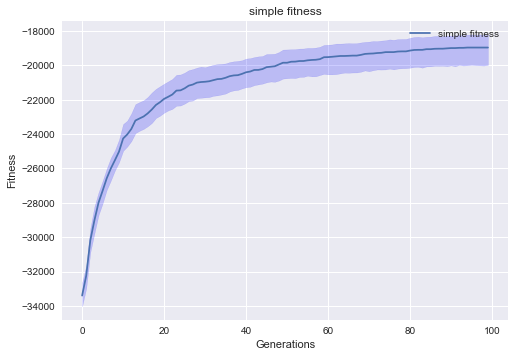

In [91]:
# plotting
plot_mean_and_bootstrapped_ci_over_time(input_data=np.transpose(np.array(experiment_results['first'])), name='simple fitness', y_label="Fitness", x_label='Generations')



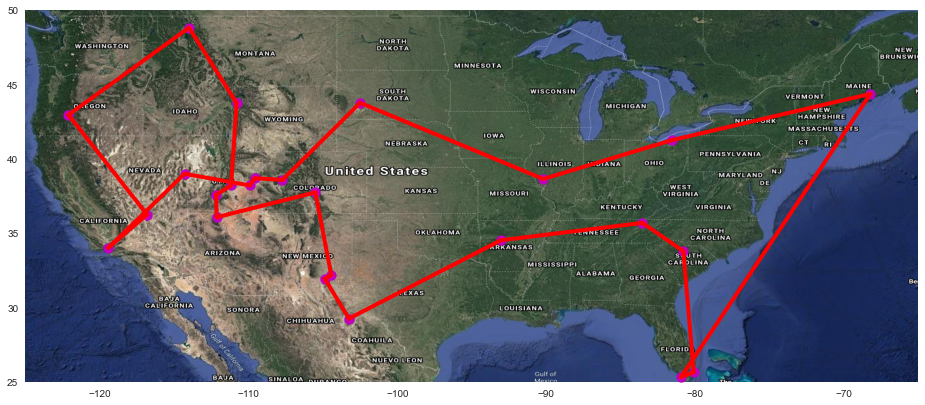

Generation: 99 
Fitness: -16157.220560414704


In [92]:
# interactive viz
# plot best solution found thus far as interactive plot
best = 0
for i in range(len(experiment_results['first'])):
    if max(experiment_results['first'][best]) < max(experiment_results['first'][i]):
        best = i
show_solution_evolution(np.array(solutions['first'][best]))

### Q7b: Analysis
Did crossover help?  Any thoughts as to why or why not?  Is this what you expected?

**Crossover did help. There were many more stepping stones and intermediate solutions. Again, I think this is because crossover added diversity to the search and a more exploratory approach to finding solutions. This is better than I expected.**

### Q8: Scaling Up
Now that you've tested some approaches on a subset of the data, let's try the best method on the full park list.  First let's re-import the complete parks list. 

In [93]:
file = open("parks_list.csv", encoding='utf8')
park_names = []
park_lat_long = []
for line in file: # get name, latitute, and longitude of park from file
    park_name = line.split(",")[0].strip()
    park_lat = float(line.split(",")[1].strip())
    park_long = float(line.split(",")[2].strip())
    
    if park_lat > -125 and park_lat < -65 and park_long > 25 and park_lat < 50: # just look at continental US
        park_names.append(park_name)
        park_lat_long.append([park_lat,park_long])
        
file.close()
park_lat_long = np.array(park_lat_long) # convert to numpy array for easier indexing/slicing

print("Number of National Parks in Continental US:",len(park_names))
print(park_names)

Number of National Parks in Continental US: 50
['Acadia', 'Arches', 'Badlands', 'Big Bend', 'Biscayne', 'Black Canyon of the Gunnison', 'Bryce Canyon', 'Canyonlands', 'Capitol Reef', 'Carlsbad Caverns', 'Channel Islands', 'Congaree', 'Crater Lake', 'Cuyahoga Valley', 'Death Valley', 'Everglades', 'Gateway Arch', 'Glacier', 'Grand Canyon', 'Grand Teton', 'Great Basin', 'Great Sand Dunes', 'Great Smoky Mountains', 'Guadalupe Mountains', 'Hot Springs', 'Indiana Dunes', 'Isle Royale', 'Joshua Tree', 'Kings Canyon', 'Lassen Volcanic', 'Mammoth Cave', 'Mesa Verde', 'Mount Rainier', 'New River Gorge', 'North Cascades', 'Olympic', 'Petrified Forest', 'Pinnacles', 'Redwood', 'Rocky Mountain', 'Saguaro', 'Sequoia', 'Shenandoah', 'Theodore Roosevelt', 'Voyageurs', 'White Sands', 'Wind Cave', 'Yellowstone', 'Yosemite', 'Zion']


This larger dataset will need to run for a bit longer, let's say `1000` generations.  We can keep all other parameters the same, though let's drop the number of independent trials down to `10`, again to keep computation reasonable.  Each run takes a little under 20 seconds on my laptop, so this should still only take a few minutes to run.  

Feel free to just run your best/favorite approach (e.g. combination of mutation and/or crossover opperators) from the smaller dataset here.  No need to compare multiple implementations right now.

In [94]:
num_runs = 10
total_generations = 1000
num_elements_to_mutate = 1
genome_length = len(park_names)
num_parents = 50
num_children = 50
tournament_size = 10
num_tournament_winners = 2
crossover = True

experiment_results['first'] = []
solutions['first'] = []

for i in range(num_runs):
    first_fit, first_sol = evolutionary_algorithm(fitness_function, total_generations, num_parents, num_children, genome_length, num_elements_to_mutate, crossover, tournament_size, num_tournament_winners)
    experiment_results['first'].append(first_fit)
    solutions['first'].append(first_sol)

Please also plot the fitness over time.  Though feel free to omit the boostrapped confidence intervals, as they take quite some time to run over 1000 generations.  

(1000, 10)
[array([-74144.17837491, -70884.99700745]), array([-71154.14525224, -67664.51095164]), array([-69221.57547325, -65051.37641832]), array([-66705.14903081, -62764.24123185]), array([-65063.31942894, -60857.22703516]), array([-64345.15585027, -60309.69389724]), array([-62717.50764249, -58206.03489482]), array([-61235.99501083, -57467.48008982]), array([-58848.54635587, -56045.06523999]), array([-57775.76590196, -54667.98532137]), array([-56950.24994216, -54189.67466262]), array([-56373.54723895, -53761.39930073]), array([-54827.18976207, -52638.70246071]), array([-54297.82492869, -51871.19271068]), array([-53428.51931971, -51597.4646429 ]), array([-53173.0955273, -51028.0965075]), array([-52225.4130306 , -49862.97993572]), array([-51672.18843593, -49567.52741903]), array([-50821.01115359, -48866.40219312]), array([-50676.95252965, -48676.58049239]), array([-50276.35159733, -48510.88419701]), array([-49653.10120493, -47694.19334218]), array([-48774.9071971 , -47023.37753134]), a

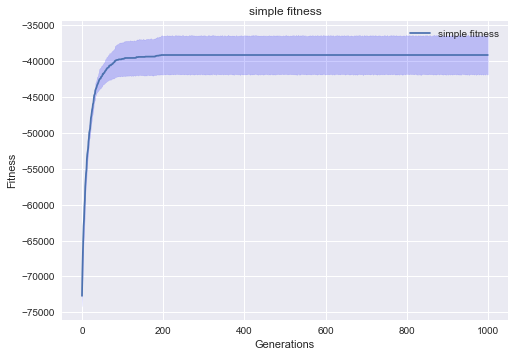

In [95]:
# plotting
plot_mean_and_bootstrapped_ci_over_time(input_data=np.transpose(np.array(experiment_results['first'])), name='simple fitness', y_label="Fitness", x_label='Generations')

Let's also visualize the optimization over time!

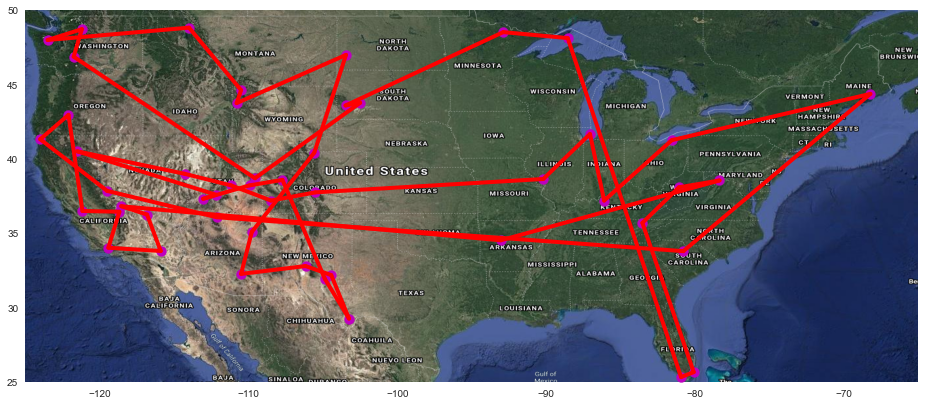

Generation: 999 
Fitness: -32786.249615448


In [96]:
# interactive viz
# plot best solution found thus far as interactive plot
best = 0
for i in range(len(experiment_results['first'])):
    if max(experiment_results['first'][best]) < max(experiment_results['first'][i]):
        best = i
show_solution_evolution(np.array(solutions['first'][best]))

### Q9: Analysis at Scale
Do you notice anything different viewing these results at scale?  Does it work as well?  What relationships or patterns do you see between the smaller and larger TSP problems that might help to inform how well of a proxy one is for the other?

**It looks like better solutions stopped being found after about 200 generations. It also looked like it had a much more difficult time finding the optimal subnetworks within different portions of the country and even somewhat connecting the subnetworks. It looks like finding the best subnetworks and connections along points that don't have many nearby neighbors are both good strategies with both the smaller and larger TSP problems. This could help to inform crossover by trying to keep these subnetworks intact while better routes are found within them.**

### Q10: Future Work
If any of these results were less than perfect solutions (including this last one at scale), what might still be standing in the way?  You might think about our discussions on search landscapes, local optima, and selection pressure, or consider additonal modificaitons to the variation pperators, selction criteria, or viability constraints, among many other ideas of potential future directions.  

**I think that selection pressure here is quite high leading to lower exploration of the space after not so many generations. I think that with this being the case, local optima are favored far greater than they might should be. The epistasis between points is obvious and is something that could use some attention in the mutation and crossover operations for better performance. This might allow for subnetworks to form and the connections between them to be optimized as well.**

### Congratulations, you made it to the end!
Nice work -- and hopefully you're starting to get the hang of these!

Please save this file as a .ipynb, and also download it as a .pdf, uploading **both** to blackboard to complete this assignment.  

For your submission, please make sure that you have renamed this file (and that the resulting pdf follows suit) to replce `[netid]` with your UVM netid.  This will greatly simplify our grading pipeline, and make sure that you receive credit for your work.  

#### Academic Integrity Attribution
During this assignment I collaborated with:

**Alican for comparison of results.**